## Reinforcement learning introduction with CartPole

### RL involves:
* Trial and error search
* Receiving and maximising reward (often delayed)
* Linking state -> action -> reward
* Must be able to sense something of their environment
* Involves uncertainty in sensing and linking action to reward
* Learning -> improved choice of actions over time
* All models find a way to balance best predicted action vs. exploration

### Elements of RL
* *Environment*: all observable and unobservable information relevant to us
* *Observation*: sensing the environment
* *State*: the perceived (or perceivable) environment 
* *Agent*: senses environment, decides on action, receives and monitors rewards
* *Action*: may be discrete (e.g. turn left) or continuous (accelerator pedal)
* *Policy* (how to link state to action; often based on probabilities)
* *Reward signal*: aim is to accumulate maximum reward over time
* *Value function* of a state: prediction of likely/possible long-term reward
* *Q*: prediction of likely/possible long-term reward of an *action*
* *Advantage*: The difference in Q between actions in a given state (sums to zero for all actions)
* *Model* (optional): a simulation of the environment

### Types of model

* *Model-based*: have model of environment (e.g. a board game)
* *Model-free*: used when environment not fully known
* *Policy-based*: identify best policy directly
* *Value-based*: estimate value of a decision
* *Off-policy*: can learn from historic data from other agent
* *On-policy*: requires active learning from current decisions


## Deep Q Networks for Reinforcement Learning

Q = The expected future rewards discounted over time. This is what we are trying to maximise.

The aim is to teach a network to take the current state observations and recommend the action with greatest Q.

<img src="./images/dqn.png" width="500"/>

Q is learned through the Bellman equation, where the Q of any state and action is the immediate reward achieved + the discounted maximum Q value (the best action taken) of next best action, where gamma is the discount rate.

$$Q(s,a)=r + \gamma.maxQ(s',a')$$

## Key DQN components

<img src="./images/dqn_components.png" width="600|"/>


## General method for Q learning:

Overall aim is to create a neural network that predicts Q. Improvement comes from improved accuracy in predicting 'current' understood Q, and in revealing more about Q as knowledge is gained (some rewards only discovered after time).

<img src="./images/dqn_process.png" width="600|"/>
    
Target networks are used to stabilise models, and are only updated at intervals. Changes to Q values may lead to changes in closely related states (i.e. states close to the one we are in at the time) and as the network tries to correct for errors it can become unstable and suddenly lose signficiant performance. Target networks (e.g. to assess Q) are updated only infrequently (or gradually), so do not have this instability problem.

## Training networks

Double DQN contains two networks. This ammendment, from simple DQN, is to decouple training of Q for current state and target Q derived from next state which are closely correlated when comparing input features.

The *policy network* is used to select action (action with best predicted Q) when playing the game.

When training, the predicted best *action* (best predicted Q) is taken from the *policy network*, but the *policy network* is updated using the predicted Q value of the next state from the *target network* (which is updated from the policy network less frequently). So, when training, the action is selected using Q values from the *policy network*, but the the *policy network* is updated to better predict the Q value of that action from the *target network*. The *policy network* is copied across to the *target network* every *n* steps (e.g. 1000).

<img src="./images/dqn_training.png" width="700|"/>

## References

van Hasselt H, Guez A, Silver D. (2015) Deep Reinforcement Learning with Double Q-learning. arXiv:150906461 [cs] http://arxiv.org/abs/1509.06461

## Code structure

<img src="./images/dqn_program_structure.png" width="700|"/>

In [1]:
################################################################################
#                           1 Import packages                                  #
################################################################################

import gym
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim

from collections import deque

In [2]:
################################################################################
#                           2 Define model parameters                          #
################################################################################

ENV_NAME = "CartPole-v0"
DISPLAY_ON_SCREEN = False

GAMMA = 0.95
LEARNING_RATE = 0.003
MEMORY_SIZE = 10000
BATCH_SIZE = 10
SYNC_TARGET_STEPS = 300
REPLAY_START_SIZE = 500

# Exploration rate (episolon) is probability of choosign a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.001
EXPLORATION_DECAY = 0.99
TARGET_REWARD = 200

In [3]:
################################################################################
#                 3 Define DQN (Duelling Deep Q Network) class                 #
#                    (Used for both policy and target nets)                    #
################################################################################

class DQN(nn.Module):

    """Deep Q Network solver"""

    def __init__(self, observation_space, action_space, neurons_per_layer=24):
        """Constructor method. Set up memory and neural nets."""

        self.exploration_rate = EXPLORATION_MAX
        self.action_space = action_space
        
        # Set up memory for state/action/reward/next_state/done
        self.memory = deque(maxlen=MEMORY_SIZE)
        
        
        # Set up network with two hidden layers
        
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, action_space)
            )
        
        # USe MSELoss as network predicting value (Q)
        self.objective = nn.MSELoss()
        
        # Use Adam optimizer
        self.optimizer = optim.Adam(
            params=self.net.parameters(), lr=LEARNING_RATE)
        

    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        # Otherwise choose best predicted outcome
        q_values = self.net(torch.FloatTensor(state))
        action = np.argmax(q_values.detach().numpy()[0]) 
        
        return action
    
  
    def forward(self, x):
        return self.net(x)

In [4]:
################################################################################
#                    4 Define policy net training function                     #
################################################################################

def optimize(policy_net, target_net, memory):
    """
    Train update TensorFlow model by sampling from memory.
    Uses policy network to predict Q.
    Uses target network to prvide target of Q for next state/action.
    Updates policy network against target network for sate/action."""
    
    
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < BATCH_SIZE:
        return    
 
    # Reduce exploration rate
    policy_net.exploration_rate *= EXPLORATION_DECAY
    policy_net.exploration_rate = max(EXPLORATION_MIN, 
                                      policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = random.sample(memory, BATCH_SIZE)
    for state, action, reward, state_next, terminal in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
       
        if not terminal:
            # For non-terminal actions get Q
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get nest state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get targen net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent gradients from being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (GAMMA * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward

        # Update neural net
        policy_net.optimizer.zero_grad()  
        loss_v = nn.MSELoss()(state_action_values, 
                            expected_state_action_values)
    
        loss_v.backward()
        policy_net.optimizer.step()
            
    return

In [5]:
################################################################################
#                            5 Define memory class                             #
################################################################################

class Memory():
    """
    Replay memomry used to train model.
    Limited length memory (using deque, double ended queue from collections).
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=MEMORY_SIZE)

    
    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [6]:
################################################################################
#                       6  Define results plotting function                    #
################################################################################

def plot_results(exploration, score):
    
    # Set up chart (ax1 and ax2 share x-axis to combine two plots on one graph)
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    
    # Plot results
    ax1.plot(exploration, label='exploration', color='g')
    ax2.plot(score, label='score reward', color='r')
    
    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('exploration', color='g')
    ax2.set_ylabel('average reward', color='r')
    
    plt.show()
    
    return  
    

In [7]:
################################################################################
#                                 7 Main program                               #
################################################################################

    ########################################################################
    #                          8 Set up environment                        #
    ########################################################################

# Set up game environemnt
env = gym.make(ENV_NAME)
# Get number of observations returned for state
observation_space = env.observation_space.shape[0]
# Get number of actions possible
action_space = env.action_space.n

    ########################################################################
    #                    9 Set up policy and target nets                   #
    ########################################################################

# Set up neural nets
policy_net = DQN(observation_space, action_space)
target_net = DQN(observation_space, action_space)
# Copy weights from policy_net to target
target_net.load_state_dict(policy_net.state_dict())
# Set target net to eval rather than training mode
target_net.eval()    

    ########################################################################
    #                            10 Set up memory                          #
    ########################################################################
    
# Set up memomry
memory = Memory()

    ########################################################################
    #                     11 Set up + start training loop                  #
    ########################################################################
    
# Set up run counter and start loop    
run = 0; all_steps = 0
# Set up results lists
exploration_list = []
score_list = []

continue_learning = True
while continue_learning:
    
    ########################################################################
    #                           12 Play episode                            #
    ########################################################################
        
    run += 1
    
    ########################################################################
    #                             13 Reset game                            #
    ########################################################################
        
    # Start run and get first state observations
    state = env.reset()
    # Reshape state into 2D array with state obsverations as first 'row'
    state = np.reshape(state, [1, observation_space])
    # Reset step count for episode
    step = 0    

    # Continue loop until episode complete
    while True:
        
        ####################################################################
        #                       14 Game episode loop                       #
        ####################################################################
        
        # Incrememnt step coints
        step += 1
        all_steps += 1
        # Option rander to screen
        if DISPLAY_ON_SCREEN:
            env.render()
            
        ####################################################################
        #                       15 Get action                              #
        ####################################################################
        
        # Get action to take
        action = policy_net.act(state)
        
        ####################################################################
        #                 16 Play action (get S', R, T)                    #
        ####################################################################
            
        # Act
        state_next, reward, terminal, info = env.step(action)
        # Update display if needed
        if DISPLAY_ON_SCREEN:
            env.render()
        # Convert step reward to negative if end of run
        reward = reward if not terminal else -reward
        # Get observations for new state
        state_next = np.reshape(state_next, [1, observation_space])
        
        ####################################################################
        #                  17 Add S/A/R/S/T to memory                      #
        ####################################################################        
        
        # Record state, action, reward, new state & terminal
        memory.remember(state, action, reward, state_next, terminal)
        # Update state
        state = state_next
        
        ####################################################################
        #                  18 Check for end of episode                     #
        ####################################################################
            
        # Actions to take if end of game episode
        if terminal:
            clear_line = ' ' * 80
            print (f'\r{clear_line}', end='')
            print(f"\rRun {run}" +
                  f", exploration {policy_net.exploration_rate:3.3f}, " +
                  f"score {step}", end='')
            exploration_list.append(policy_net.exploration_rate)
            score_list.append(step)
            
            ################################################################
            #             18b Check for end of learning                    #
            ################################################################
            
            if step >= TARGET_REWARD:
                continue_learning = False
            
            # End current episode    
            break

        ####################################################################
        #                        19 Update policy net                      #
        ####################################################################
            
        # Avoid training model if memory is not of sufficient length
        if len(memory.memory) < REPLAY_START_SIZE:
            continue

        # Update policy net 
        optimize(policy_net, target_net, memory.memory)
        
        ################################################################
        #             20 Update target net periodically                #
        ################################################################

        # Update the target network at intervals
        if all_steps % SYNC_TARGET_STEPS == 0:
             target_net.load_state_dict(policy_net.state_dict())

Run 98, exploration 0.001, score 200                                            

Plot exploration and score.

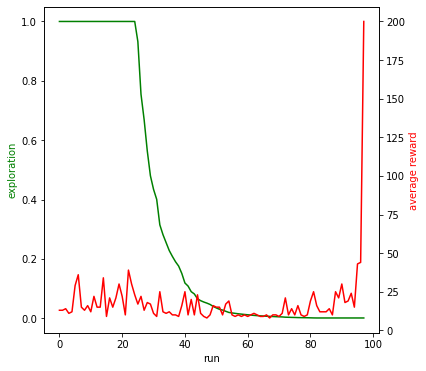

In [8]:
plot_results(exploration_list, score_list)

Run the model 10 times (we stopped the model as soon as it reached 200 steps - it is possible/likely this has not yet been optimally trained to achieve a score of 200 steps every single run).

In [9]:
obs = env.reset()    
totals = []
for episode in range(10):
    episode_reward = 0
    obs = env.reset()
    for step in range(200):
        obs = np.reshape(obs, [1, observation_space])
        action = policy_net.act(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        # Pole has fallen over if done is True
        if done:
            break
    totals.append(episode_reward)
    env.close()

print ("Average: {0:.1f}".format(np.mean(totals)))    
print ("Stdev: {0:.1f}".format(np.std(totals)))
print ("Minumum: {0:.0f}".format(np.min(totals)))
print ("Maximum: {0:.0f}".format(np.max(totals)))

Average: 194.6
Stdev: 14.9
Minumum: 150
Maximum: 200


Observe one run of the model.

In [12]:
obs = env.reset()    
for step in range(200):
    env.render()
    obs = np.reshape(obs, [1, observation_space])   
    action = policy_net.act(obs)
    obs, reward, done, info = env.step(action)
    # Pole has fallen over if done is True
    if done:
        break
env.close()